<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Seyed Mohammad Eshtehardian'
std_id = '402200948'

In [2]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
import matplotlib as mpl

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [3]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [4]:
# TODO: Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 850kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 53.5MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.67MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Merge the two datasets to train the model on the images.

In [5]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset((train_dataset, test_dataset))
merged_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [6]:
def plot_class_distribution(dataloader):
    # TODO: Initialize a dictionary to count occurrences of each class
    dic = {}
    for i in range(10):
      dic[i] = 0
    # TODO: Iterate through the DataLoader to count the labels
    for (images, labels) in dataloader:
      counts = torch.bincount(labels)
      for i in range(len(counts)):
        dic[i] += counts[i]
    # TODO: Plot the histogram
    plt.figure(dpi=120)
    plt.bar(dic.keys(), dic.values(), width=0.8,
            color='blue', edgecolor='black')
    plt.xticks(range(10))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

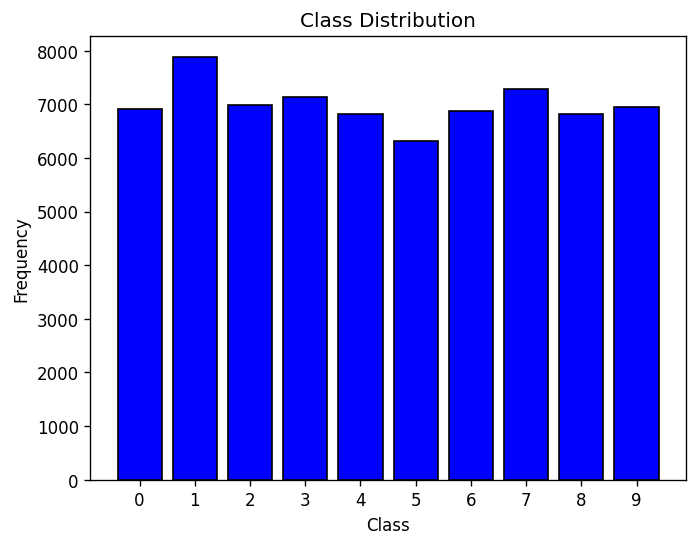

In [7]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [8]:
def plot_class_averages(dataloader):
    # TODO: Iterate over the DataLoader to accumulate sums and counts
    count_dic = {}
    sum_dic = {}
    for i in range(10):
      count_dic[i] = 0
      sum_dic[i] = np.zeros((1, 28, 28))
    for (images, labels) in dataloader:
      for i in range(len(labels)):
        count_dic[labels[i].item()] += 1
        sum_dic[labels[i].item()] += images[i].cpu().numpy()
    # TODO: Calculate the average images for each class
    avg_dic = {}
    for i in range(10):
      avg_dic[i] = sum_dic[i].reshape(28, 28) / count_dic[i]
    # TODO: Plot the averages
    fig, axs = plt.subplots(2, 5)
    for i in range(2):
      for j in range(5):
        axs[i, j].imshow(avg_dic[5*i+j], cmap='gray')
        axs[i, j].set_title(f'Class {5*i+j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

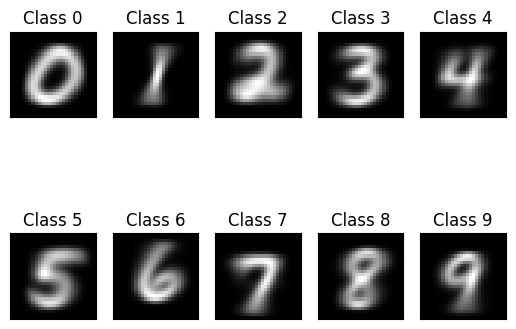

In [9]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [10]:
class VAE(nn.Module):

    def __init__(self, latent_dim=2):
        # TODO
        super(VAE, self).__init__()

        # encoder layers
        self.enc_in = nn.Linear(784, 500)
        self.enc_hid = nn.Linear(500, 100)
        self.enc_mean = nn.Linear(100, latent_dim)
        self.enc_log_var = nn.Linear(100, latent_dim)

        # decoder layers
        self.dec_in = nn.Linear(latent_dim, 100)
        self.dec_hid = nn.Linear(100, 500)
        self.dec_out = nn.Linear(500, 784)

        # nonlinearity
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        # TODO
        y = self.relu(self.enc_in(x))
        z = self.relu(self.enc_hid(y))
        mean, log_var = self.enc_mean(z), self.enc_log_var(z)
        return mean, log_var

    def reparameterization(self, mean, log_var):
        # TODO
        std = torch.exp(1/2*log_var)
        epsilon = torch.randn_like(std)
        return std * epsilon + mean

    def decode(self, x):
        # TODO
        y = self.relu(self.dec_in(x))
        z = self.relu(self.dec_hid(y))
        return self.sigmoid(self.dec_out(z))

    def forward(self, x):
        # TODO
        mean, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [11]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [12]:
def loss_function(x, x_hat, mean, log_var, alpha=0.5):
    # TODO
    bce_loss = nn.BCELoss(reduction='sum')
    rec_loss = bce_loss(x_hat, x.view(-1, 784))
    kl_loss = torch.sum(-1/2 - log_var + 1/2 * (torch.exp(2*log_var) + mean.pow(2)))
    return 2 * (alpha * rec_loss + (1 - alpha) * kl_loss)

Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [13]:
def plot_losses(losses):
    # TODO
    plt.figure(dpi=120)
    plt.plot(losses, 'b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE Training')
    plt.grid()


def train(model, optimizer, n_epochs=50, losses=losses, dataloader=merged_loader):
    # TODO
    pbar = trange(n_epochs, desc='Loss: Nan', leave=True)
    for i in pbar:
      model.train()
      loss = 0
      for idx, (images, labels) in enumerate(dataloader):
        images = images.cuda()
        optimizer.zero_grad()
        x_hat, mean, log_var = model(images)
        loss_batch = loss_function(images, x_hat, mean, log_var)
        loss_batch.backward()
        loss += loss_batch.item()
        optimizer.step()
      loss /= len(dataloader.dataset)
      pbar.set_description(f"Loss: {loss}", refresh=True)
      losses.append(loss)
    plot_losses(losses)
    torch.save(model.state_dict(), 'checkpoint.pth')
    return model, losses

Loss: 142.29717648577008: 100%|██████████| 50/50 [09:30<00:00, 11.40s/it]


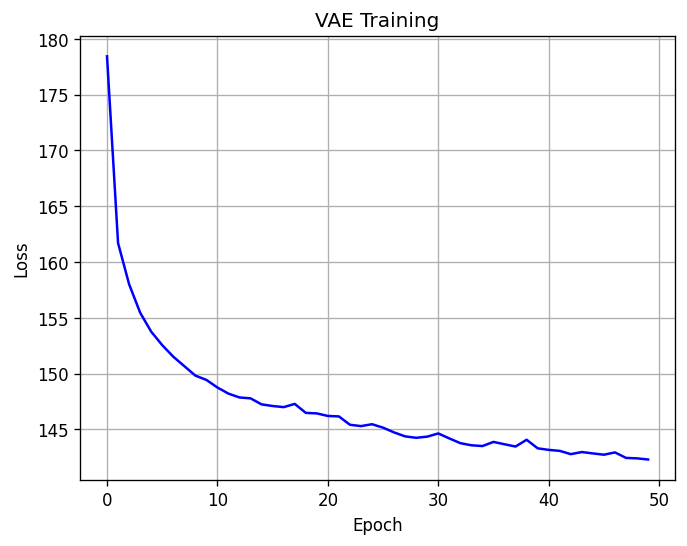

In [14]:
model, losses = train(model, optimizer)

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [34]:
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the dataloader and plot the latent space
    dic_x, dic_y = {}, {}
    for i in range(10):
      dic_x[i] = []
      dic_y[i] = []
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        if idx == batch_count:
          break
        images = images.cuda()
        for i in range(len(labels)):
          mean, log_var = vae.encode(images[i].view(-1, 784))
          latent = vae.reparameterization(mean, log_var).cpu().numpy()
          dic_x[labels[i].item()].append(latent[0][0])
          dic_y[labels[i].item()].append(latent[0][1])
    plt.figure(dpi=120)
    cmap = plt.get_cmap('jet', 10)
    for i in range(10):
      c = (np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))
      plt.scatter(dic_x[i], dic_y[i], color=cmap(i), ec='black')
    plt.title(title)
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    norm = mpl.colors.Normalize(vmin=0, vmax=10)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(0, 9, 10), ax=plt.gca())
    plt.show()

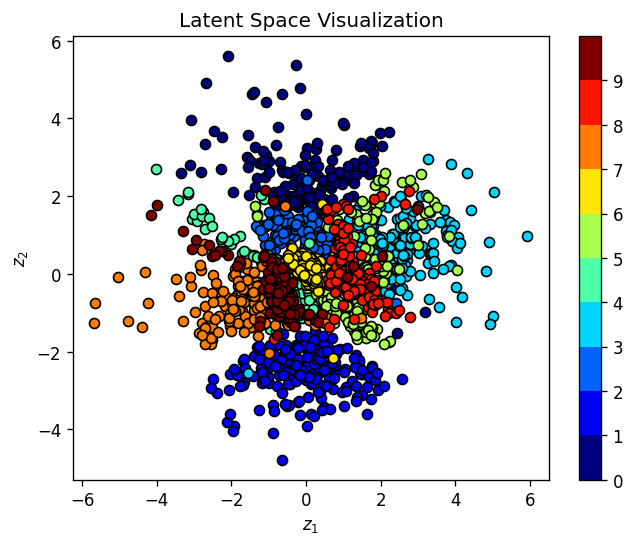

In [35]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [32]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    dic_x, dic_y = {}, {}
    for i in range(10):
      dic_x[i] = []
      dic_y[i] = []
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        if idx == batch_count:
          break
        images = images.cuda()
        images = 1 - images
        for i in range(len(labels)):
          mean, log_var = vae.encode(images[i].view(-1, 784))
          latent = vae.reparameterization(mean, log_var).cpu().numpy()
          dic_x[labels[i].item()].append(latent[0][0])
          dic_y[labels[i].item()].append(latent[0][1])
    plt.figure(dpi=120)
    cmap = plt.get_cmap('jet', 10)
    for i in range(10):
      c = (np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))
      plt.scatter(dic_x[i], dic_y[i], color=cmap(i), ec='black')
    plt.title(title)
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    norm = mpl.colors.Normalize(vmin=0, vmax=10)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(0, 9, 10), ax=plt.gca())
    plt.show()

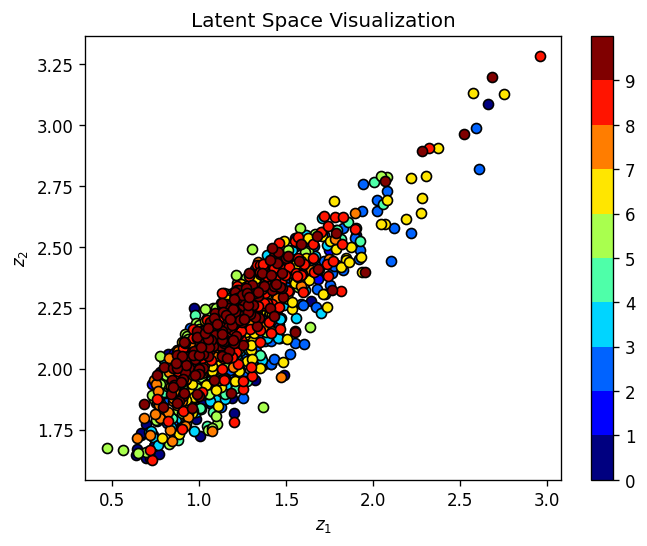

In [33]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

We can see that the datapoints lie near the origin but the others lie far from origin. So if we see a latent far from the origin we can say it is an anomoly. If we use autoencoder then we can use the reconstruction error of the sample to determine if it is a anomoly or not.

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [21]:
def generate_digit(mean, var):
    # TODO: Return the generated image
    epsilon = torch.randn_like(mean)
    z = var * epsilon + mean
    with torch.no_grad():
      image = model.decode(z).cpu().numpy().reshape(28, 28)
    return image

Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [30]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid
    manifold = np.zeros((n*digit_size, n*digit_size))
    # TODO: Generate images for the grid
    z_min, z_max = -1, 1
    for i in range(n):
      for j in range(n):
        x, y = (i % n) * digit_size, (j % n) * digit_size
        z1, z2 = i/(n-1)*(z_max-z_min)+z_min, j/(n-1)*(z_max-z_min)+z_min
        z = torch.Tensor([z1, z2]).cuda()
        image = model.decode(z).detach().cpu().numpy().reshape(28, 28)
        manifold[x:x+digit_size, y:y+digit_size] = image.copy()
    # TODO: Display the results
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(manifold, cmap='gray')
    plt.title('VAE Generated Samples')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.xticks([])
    plt.yticks([])

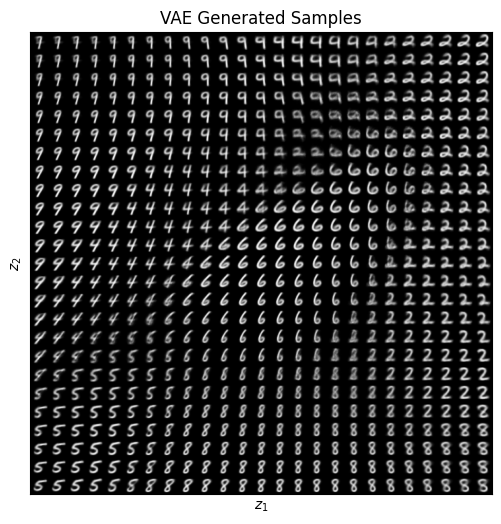

In [31]:
plot_latent_space(model, figsize=6)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*

If we sample from outside of this region, we could expect that all of the samples be the same. If we use a simple autoencoder, we cannot generate sample because the latent space will me deterministic and it will not be meaningful.